<a href="https://colab.research.google.com/github/vassilybar/cs231n_solutions_colab/blob/master/assignment_2/BatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. 
One idea along these lines is batch normalization which was proposed by [3] in 2015.

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [3] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [3] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[3] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [1]:
!rm -rf * && \
 wget 'http://cs231n.github.io/assignments/2018/spring1718_assignment2.zip' && \
 unzip 'spring1718_assignment2.zip' && \
 mv assignment2/cs231n . && \
 pushd cs231n/datasets && \
 chmod +x ./get_datasets.sh && \
 ./get_datasets.sh && \
 popd && \
 rm -rf assignment2

--2019-01-30 18:20:20--  http://cs231n.github.io/assignments/2018/spring1718_assignment2.zip
Resolving cs231n.github.io (cs231n.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to cs231n.github.io (cs231n.github.io)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116579 (114K) [application/zip]
Saving to: ‘spring1718_assignment2.zip’

spring1718_assignme 100%[===================>] 113.85K  --.-KB/s    in 0.02s   

2019-01-30 18:20:20 (4.80 MB/s) - ‘spring1718_assignment2.zip’ saved [116579/116579]

Archive:  spring1718_assignment2.zip
   creating: assignment2/
 extracting: assignment2/.gitignore  
  inflating: assignment2/BatchNormalization.ipynb  
  inflating: assignment2/collectSubmission.sh  
  inflating: assignment2/ConvolutionalNetworks.ipynb  
   creating: assignment2/cs231n/
  inflating: assignment2/cs231n/.gitignore  
 extracting: assignment2/cs231n/__init__.py  
   creating: assignment2/cs231n/classifiers/

In [0]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
#from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
#from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

In [3]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Batch normalization: forward
In the file `cs231n/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above would be helpful!

In [0]:
from builtins import range
import numpy as np


def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    N = x.shape[0]
    out = x.reshape(N, -1).dot(w) + b
    cache = (x, w, b)
    
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    
    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)
    
    return dx, dw, db


def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    
    out = np.maximum(0, x)
    cache = x
    
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    
    dx = dout * (x > 0)
    
    return dx


def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta.                     #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #                                                                     #
        # Note that though you should be keeping track of the running         #
        # variance, you should normalize the data based on the standard       #
        # deviation (square root of variance) instead!                        # 
        # Referencing the original paper (https://arxiv.org/abs/1502.03167)   #
        # might prove to be helpful.                                          #
        #######################################################################
        
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        xh = (x - batch_mean) / np.sqrt(batch_var + eps)
        out = gamma * xh + beta
        running_mean = momentum * running_mean + (1 - momentum) * batch_mean
        running_var = momentum * running_var + (1 - momentum) * batch_var
        
        cache = (x, xh, gamma, beta, batch_mean, batch_var, eps)
        
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        
        x = (x - running_mean) / np.sqrt(running_var + eps)
        out = gamma * x + beta
        
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache


def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    # Referencing the original paper (https://arxiv.org/abs/1502.03167)       #
    # might prove to be helpful.                                              #
    ###########################################################################
    
    x, xh, gamma, beta, mu, sigma_sq, eps = cache
    m = x.shape[0]
    dgamma = np.sum(dout * xh, axis=0)
    dbeta = np.sum(dout, axis=0)
    dxh = dout * gamma
    dsigma = -0.5 * np.sum(dxh * (x - mu), axis=0) * (sigma_sq + eps)**(-3/2)
    dmu = - np.sum(dxh, axis=0) / np.sqrt(sigma_sq + eps) - \
                2 * dsigma * np.sum(x - mu, axis=0) / m
    dx = dxh / np.sqrt(sigma_sq + eps) + 2 * dsigma * (x - mu) / m + \
                                                    dmu / m
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta


def batchnorm_backward_alt(dout, cache):
    """
    Alternative backward pass for batch normalization.

    For this implementation you should work out the derivatives for the batch
    normalizaton backward pass on paper and simplify as much as possible. You
    should be able to derive a simple expression for the backward pass. 
    See the jupyter notebook for more hints.
     
    Note: This implementation should expect to receive the same cache variable
    as batchnorm_backward, but might not use all of the values in the cache.

    Inputs / outputs: Same as batchnorm_backward
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    #                                                                         #
    # After computing the gradient with respect to the centered inputs, you   #
    # should be able to compute gradients with respect to the inputs in a     #
    # single statement; our implementation fits on a single 80-character line.#
    ###########################################################################
    
    x, xh, gamma, beta, mu, sigma_sq, eps = cache
    m = x.shape[0]
    std = np.sqrt(sigma_sq + eps)
    
    dgamma = np.sum(dout * xh, axis=0)
    dbeta = np.sum(dout, axis=0)
    dx = gamma * ((dout - dbeta / m) + dgamma * (np.sum(xh, axis=0) - xh) / m) / std
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta


def layernorm_forward(x, gamma, beta, ln_param):
    """
    Forward pass for layer normalization.

    During both training and test-time, the incoming data is normalized per data-point,
    before being scaled by gamma and beta parameters identical to that of batch normalization.
    
    Note that in contrast to batch normalization, the behavior during train and test-time for
    layer normalization are identical, and we do not need to keep track of running averages
    of any sort.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - ln_param: Dictionary with the following keys:
        - eps: Constant for numeric stability

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    out, cache = None, None
    eps = ln_param.get('eps', 1e-5)
    ###########################################################################
    # TODO: Implement the training-time forward pass for layer norm.          #
    # Normalize the incoming data, and scale and  shift the normalized data   #
    #  using gamma and beta.                                                  #
    # HINT: this can be done by slightly modifying your training-time         #
    # implementation of  batch normalization, and inserting a line or two of  #
    # well-placed code. In particular, can you think of any matrix            #
    # transformations you could perform, that would enable you to copy over   #
    # the batch norm code and leave it almost unchanged?                      #
    ###########################################################################
    
    batch_mean = np.mean(x, axis=1).reshape(-1,1)
    batch_var = np.var(x, axis=1).reshape(-1,1)
    xh = (x - batch_mean) / np.sqrt(batch_var + eps)
    out = gamma * xh + beta
    
    cache = (x, xh, gamma, beta, batch_mean, batch_var, eps)
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return out, cache


def layernorm_backward(dout, cache):
    """
    Backward pass for layer normalization.

    For this implementation, you can heavily rely on the work you've done already
    for batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from layernorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for layer norm.                       #
    #                                                                         #
    # HINT: this can be done by slightly modifying your training-time         #
    # implementation of batch normalization. The hints to the forward pass    #
    # still apply!                                                            #
    ###########################################################################
    
    x, xh, gamma, beta, mu, sigma_sq, eps = cache
    m = x.shape[1]
    dgamma = np.sum(dout * xh, axis=0)
    dbeta = np.sum(dout, axis=0)
    std = np.sqrt(sigma_sq + eps)
    dx = ((gamma * dout - np.sum(gamma * dout, axis=1).reshape(-1,1) / m) + \
                  np.sum(gamma * dout * xh, axis=1).reshape(-1,1) * (np.sum(xh, axis=1).reshape(-1,1) - xh) / m) / std
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dgamma, dbeta
  
  
def softmax_loss(x, y):
  """
  Computes the loss and gradient for softmax classification.
  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C
  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx

In [5]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [5.32907052e-17 7.04991621e-17 1.85962357e-17]
  stds:   [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [0.99999999 1.99999999 2.99999999]



In [6]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:   [1.01531428 1.01238373 0.97819988]



## Batch normalization: backward
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Once you have finished, run the following to numerically check your backward pass.

In [7]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.702926400705332e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


## Batch normalization: alternative backward
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For example, you can derive a very simple formula for the sigmoid function's backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can do a similar simplification for the batch normalization backward pass too.  
Given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 
we first calculate the mean $\mu=\frac{1}{N}\sum_{k=1}^N x_k$ and variance $v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2.$    
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma=\sqrt{v+\epsilon}$  and normalized data $Y$ with $y_i=\frac{x_i-\mu}{\sigma}.$


The meat of our problem is to get $\frac{\partial L}{\partial X}$ from the upstream gradient $\frac{\partial L}{\partial Y}.$ It might be challenging to directly reason about the gradients over $X$ and $Y$ - try reasoning about it in terms of $x_i$ and $y_i$ first.

You will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$. You should make sure each of the intermediary steps are all as simple as possible. 

After doing so, implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

In [8]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  1.1069867327106926e-10
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 3.08x


## Fully Connected Nets with Batch Normalization
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs231n/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the `normalization` flag is set to `"batchnorm"` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

HINT: You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`. If you decide to do so, do it in the file `cs231n/classifiers/fc_net.py`.

In [0]:
def affine_relu_forward(x, w, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db
  
def affine_bn_relu_forward(x, w, b, gamma, beta, bn_param):
    """
    Convenience layer that performs an affine transform, batch normalization and ReLU
    """
    h, fc_cache = affine_forward(x, w, b)
    b, bn_cache = batchnorm_forward(h, gamma, beta, bn_param)
    out, relu_cache = relu_forward(b)
    cache = (fc_cache, bn_cache, relu_cache)
    return out, cache

def affine_bn_relu_backward(dout, cache):
    """
        Backward pass for the affine-bn-relu convenience layer
    """
    fc_cache, bn_cache, relu_cache = cache
    drelu = relu_backward(dout, relu_cache)
    dbatch, dgamma, dbeta = batchnorm_backward_alt(drelu, bn_cache)
    dx, dw, db = affine_backward(dbatch, fc_cache)
    return dx, dw, db, dgamma, dbeta
  
def affine_ln_relu_forward(x, w, b, gamma, beta, bn_param):
    """
    Convenience layer that performs an affine transform, batch normalization and ReLU
    """
    h, fc_cache = affine_forward(x, w, b)
    b, bn_cache = layernorm_forward(h, gamma, beta, bn_param)
    out, relu_cache = relu_forward(b)
    cache = (fc_cache, bn_cache, relu_cache)
    return out, cache

def affine_ln_relu_backward(dout, cache):
    """
        Backward pass for the affine-bn-relu convenience layer
    """
    fc_cache, bn_cache, relu_cache = cache
    drelu = relu_backward(dout, relu_cache)
    dbatch, dgamma, dbeta = layernorm_backward(drelu, bn_cache)
    dx, dw, db = affine_backward(dbatch, fc_cache)
    return dx, dw, db, dgamma, dbeta

In [0]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch/layer normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
                 dropout=1, normalization=None, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
          are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}
    
        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        ############################################################################

        all_dims = np.hstack((input_dim, hidden_dims, num_classes))

        for i in range(self.num_layers):
            self.params['W%d' % (i + 1)] = weight_scale * np.random.randn(all_dims[i], all_dims[i+1])
            self.params['b%d' % (i + 1)] = np.zeros(all_dims[i+1])

        if self.normalization=='batchnorm' or self.normalization=='layernorm':
          for i in range(self.num_layers - 1):
              self.params['gamma%d' % (i + 1)] = np.ones(all_dims[i+1])
              self.params['beta%d' % (i + 1)] = np.zeros(all_dims[i+1])

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization=='batchnorm':
            self.bn_params = [{'mode': 'train'} for i in range(self.num_layers - 1)]
        if self.normalization=='layernorm':
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param['mode'] = mode
        if self.normalization=='batchnorm':
            for bn_param in self.bn_params:
                bn_param['mode'] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################

        cache = []
        layer_temp = X

        for i in range(1, self.num_layers):
          
          if self.normalization=='batchnorm':
            layer_temp, cache_temp = affine_bn_relu_forward(layer_temp,
                                                      self.params['W%d' %i],
                                                      self.params['b%d' %i],
                                                      self.params['gamma%d' %i],
                                                      self.params['beta%d' %i],
                                                      self.bn_params[i-1])
          if self.normalization=='layernorm':
            layer_temp, cache_temp = affine_ln_relu_forward(layer_temp,
                                                      self.params['W%d' %i],
                                                      self.params['b%d' %i],
                                                      self.params['gamma%d' %i],
                                                      self.params['beta%d' %i],
                                                      self.bn_params[i-1])

          if self.normalization==None:
            layer_temp, cache_temp = affine_relu_forward(layer_temp,
                                                      self.params['W%i' %i], 
                                                      self.params['b%i' %i])
          cache.append(cache_temp)

        scores, cache_temp = affine_forward(layer_temp,
                                                self.params['W%i' %self.num_layers], 
                                                self.params['b%i' %self.num_layers])
        cache.append(cache_temp)

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}

        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        ############################################################################

        loss, dl = softmax_loss(scores, y)

        dl, grads['W%i' %self.num_layers], \
            grads['b%i' %self.num_layers] = affine_backward(dl, cache.pop())

        grads['W%i' %self.num_layers] += self.reg * self.params['W%i' %self.num_layers]
        loss += 0.5 * self.reg * (np.sum(self.params['W%i' %self.num_layers] ** 2))

        for i in reversed(range(1, self.num_layers)):
          if self.normalization=='batchnorm':
            dl, grads['W%d' %i], \
                grads['b%d' %i], \
                grads['gamma%d' %i], \
                grads['beta%d' %i] = affine_bn_relu_backward(dl, cache.pop())
            
          if self.normalization=='layernorm':
            dl, grads['W%d' %i], \
                grads['b%d' %i], \
                grads['gamma%d' %i], \
                grads['beta%d' %i] = affine_ln_relu_backward(dl, cache.pop())
            
          if self.normalization==None:
            dl, grads['W%i' %i], grads['b%i' %i] = affine_relu_backward(dl, cache.pop())

          grads['W%i' %i] += self.reg * self.params['W%i' %i]
          loss += 0.5 * self.reg * (np.sum(self.params['W%i' %i] ** 2))

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [11]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 5.65e-06
W3 relative error: 4.14e-10
b1 relative error: 2.66e-07
b2 relative error: 4.44e-08
b3 relative error: 1.02e-10
beta1 relative error: 7.33e-09
beta2 relative error: 1.17e-09
gamma1 relative error: 7.47e-09
gamma2 relative error: 3.35e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 1.11e-08
b1 relative error: 1.38e-08
b2 relative error: 7.99e-07
b3 relative error: 2.10e-10
beta1 relative error: 6.32e-09
beta2 relative error: 3.48e-09
gamma1 relative error: 6.27e-09
gamma2 relative error: 4.14e-09


# Batchnorm for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [12]:
%%writefile optim.py

import numpy as np

def sgd(w, dw, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w))

    next_w = None
    
    v = config['momentum'] * v - config['learning_rate'] * dw
    next_w = w + v
    config['velocity'] = v

    return next_w, config



def rmsprop(w, dw, config=None):
    if config is None: config = {}
    learning_rate = config.setdefault('learning_rate', 1e-2)
    decay_rate = config.setdefault('decay_rate', 0.99)
    eps = config.setdefault('epsilon', 1e-8)
    config.setdefault('cache', np.zeros_like(w))

    next_w = None
    
    config['cache'] = decay_rate * config['cache'] + (1 - decay_rate) * dw ** 2
    next_w = w - learning_rate * dw / (np.sqrt(config['cache']) + eps)
    
    return next_w, config


def adam(w, dw, config=None):
    if config is None: config = {}
    learning_rate = config.setdefault('learning_rate', 1e-3)
    beta1 = config.setdefault('beta1', 0.9)
    beta2 = config.setdefault('beta2', 0.999)
    eps = config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    t = config.setdefault('t', 0)

    next_w = None
    
    t += 1
    # t is your iteration counter going from 1 to infinity
    config['m'] = beta1 * config['m'] + (1 - beta1) * dw
    mt = config['m'] / (1 - beta1 ** t)
    config['v'] = beta2 * config['v'] + (1 - beta2) * (dw ** 2)
    vt = config['v'] / (1 - beta2 ** t)
    next_w = w - learning_rate * mt / (np.sqrt(vt) + eps)

    return next_w, config

Writing optim.py


In [0]:
from __future__ import print_function, division
from future import standard_library
standard_library.install_aliases()
from builtins import range
from builtins import object
import os
import pickle as pickle

import optim

class Solver(object):
    
    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.
        """
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)
        self.num_train_samples = kwargs.pop('num_train_samples', 1000)
        self.num_val_samples = kwargs.pop('num_val_samples', None)

        self.checkpoint_name = kwargs.pop('checkpoint_name', None)
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config


    def _save_checkpoint(self):
        if self.checkpoint_name is None: return
        checkpoint = {
          'model': self.model,
          'update_rule': self.update_rule,
          'lr_decay': self.lr_decay,
          'optim_config': self.optim_config,
          'batch_size': self.batch_size,
          'num_train_samples': self.num_train_samples,
          'num_val_samples': self.num_val_samples,
          'epoch': self.epoch,
          'loss_history': self.loss_history,
          'train_acc_history': self.train_acc_history,
          'val_acc_history': self.val_acc_history,
        }
        filename = '%s_epoch_%d.pkl' % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(checkpoint, f)


    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = (t == 0)
            last_it = (t == num_iterations - 1)
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train,
                    num_samples=self.num_train_samples)
                val_acc = self.check_accuracy(self.X_val, self.y_val,
                    num_samples=self.num_val_samples)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                           self.epoch, self.num_epochs, train_acc, val_acc))

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

In [14]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 200) loss: 2.340975
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.115000
(Epoch 1 / 10) train acc: 0.321000; val_acc: 0.276000
(Iteration 21 / 200) loss: 1.968983
(Epoch 2 / 10) train acc: 0.402000; val_acc: 0.302000
(Iteration 41 / 200) loss: 2.164388
(Epoch 3 / 10) train acc: 0.478000; val_acc: 0.307000
(Iteration 61 / 200) loss: 1.624921
(Epoch 4 / 10) train acc: 0.508000; val_acc: 0.310000
(Iteration 81 / 200) loss: 1.252777
(Epoch 5 / 10) train acc: 0.579000; val_acc: 0.293000
(Iteration 101 / 200) loss: 1.297135
(Epoch 6 / 10) train acc: 0.624000; val_acc: 0.336000
(Iteration 121 / 200) loss: 1.087276
(Epoch 7 / 10) train acc: 0.712000; val_acc: 0.347000
(Iteration 141 / 200) loss: 1.111694
(Epoch 8 / 10) train acc: 0.738000; val_acc: 0.327000
(Iteration 161 / 200) loss: 0.779071
(Epoch 9 / 10) train acc: 0.779000; val_acc: 0.306000
(Iteration 181 / 200) loss: 0.770726
(Epoch 10 / 10) train acc: 0.814000; val_acc: 0.311000
(Iteration 1 / 200) loss: 2.302332
(Epoch

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

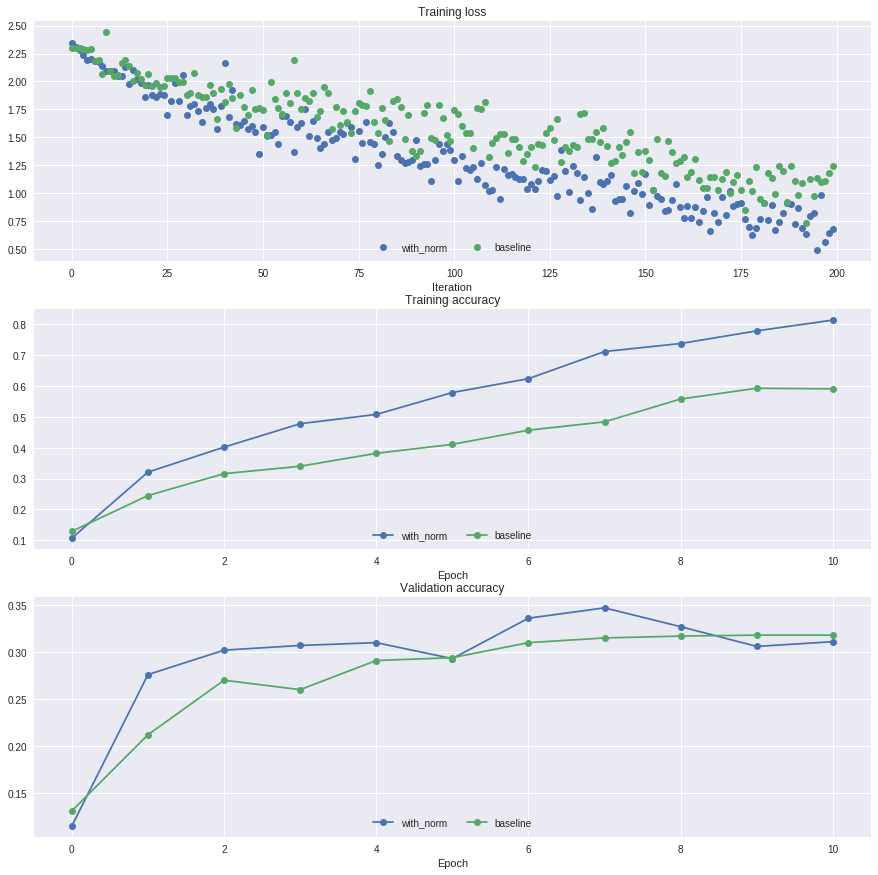

In [15]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization and initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [16]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers_ws[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:381: RuntimeWarning: divide by zero encountered in log


Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


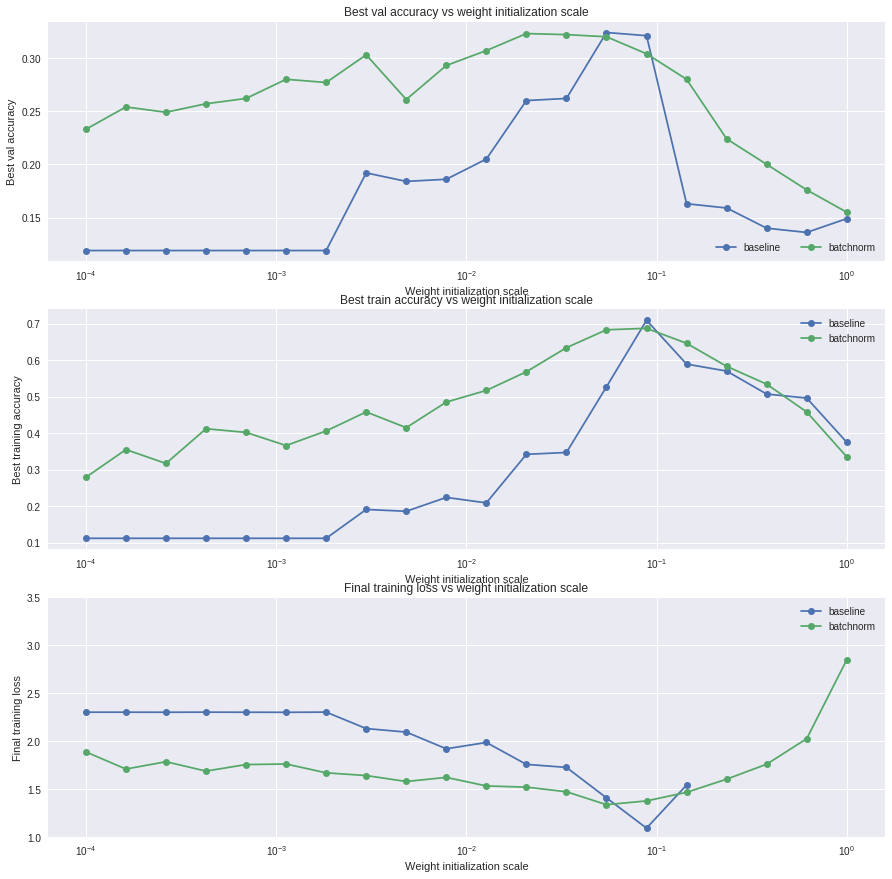

In [17]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))
  
  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
Describe the results of this experiment. How does the scale of weight initialization affect models with/without batch normalization differently, and why?

# Batch normalization and batch size
We will now run a small experiment to study the interaction of batch normalization and batch size.

The first cell will train 6-layer networks both with and without batch normalization using different batch sizes. The second layer will plot training accuracy and validation set accuracy over time.

In [18]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Try training a very deep net with batchnorm
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


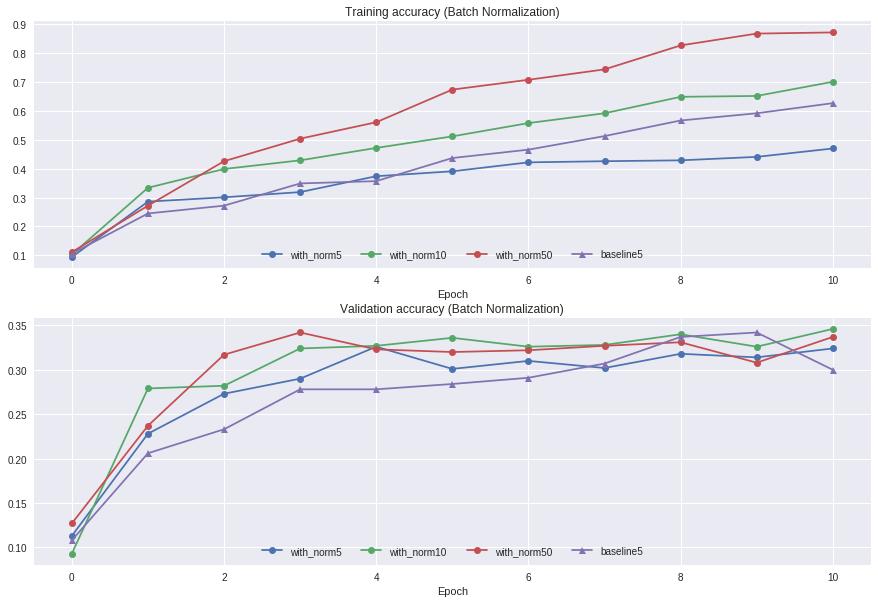

In [19]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
Describe the results of this experiment. What does this imply about the relationship between batch normalization and batch size? Why is this relationship observed?


# Layer Normalization
Batch normalization has proved to be effective in making networks easier to train, but the dependency on batch size makes it less useful in complex networks which have a cap on the input batch size due to hardware limitations. 

Several alternatives to batch normalization have been proposed to mitigate this problem; one such technique is Layer Normalization [4]. Instead of normalizing over the batch, we normalize over the features. In other words, when using Layer Normalization, each feature vector corresponding to a single datapoint is normalized based on the sum of all terms within that feature vector.

[4] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

## Inline Question 3:
Which of these data preprocessing steps is analogous to batch normalization, and which is analogous to layer normalization?

1. Scaling each image in the dataset, so that the RGB channels for each row of pixels within an image sums up to 1.
2. Scaling each image in the dataset, so that the RGB channels for all pixels within an image sums up to 1.  
3. Subtracting the mean image of the dataset from each image in the dataset.
4. Setting all RGB values to either 0 or 1 depending on a given threshold.


# Layer Normalization: Implementation

Now you'll implement layer normalization. This step should be relatively straightforward, as conceptually the implementation is almost identical to that of batch normalization. One significant difference though is that for layer normalization, we do not keep track of the moving moments, and the testing phase is identical to the training phase, where the mean and variance are directly calculated per datapoint.

Here's what you need to do:

* In `cs231n/layers.py`, implement the forward pass for layer normalization in the function `layernorm_backward`. 

Run the cell below to check your results.
* In `cs231n/layers.py`, implement the backward pass for layer normalization in the function `layernorm_backward`. 

Run the second cell below to check your results.
* Modify `cs231n/classifiers/fc_net.py` to add layer normalization to the `FullyConnectedNet`. When the `normalization` flag is set to `"layernorm"` in the constructor, you should insert a layer normalization layer before each ReLU nonlinearity. 

Run the third cell below to run the batch size experiment on layer normalization.

In [20]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)
# Means should be close to zero and stds close to one
print('After layer normalization (gamma=1, beta=0)')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])
# Now means should be close to beta and stds close to gamma
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

Before layer normalization:
  means:  [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:   [10.07429373 28.39478981 35.28360729  4.01831507]

After layer normalization (gamma=1, beta=0)
  means:  [ 4.81096644e-16 -7.40148683e-17  2.22044605e-16 -5.92118946e-16]
  stds:   [0.99999995 0.99999999 1.         0.99999969]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means:  [5. 5. 5. 5.]
  stds:   [2.99999985 2.99999998 2.99999999 2.99999907]



In [21]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

#You should expect to see relative errors between 1e-12 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.4336148913411311e-09
dgamma error:  4.519489546032799e-12
dbeta error:  2.276445013433725e-12


# Layer Normalization and batch size

We will now run the previous batch size experiment with layer normalization instead of batch normalization. Compared to the previous experiment, you should see a markedly smaller influence of batch size on the training history!

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


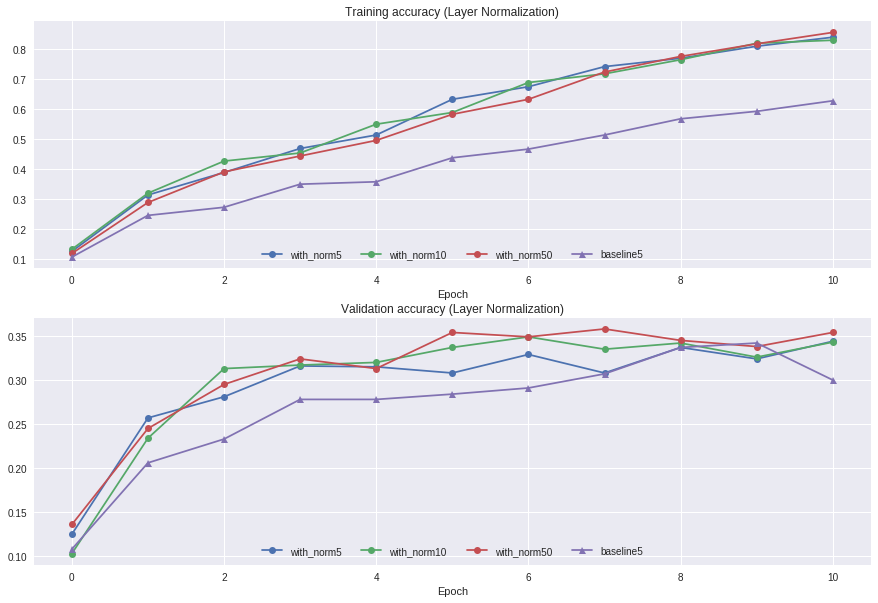

In [22]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layernorm')

plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 4:
When is layer normalization likely to not work well, and why?

1. Using it in a very deep network
2. Having a very small dimension of features
3. Having a high regularization term


